In [58]:
#import modeling libraries
import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import scipy.stats as stats
import datetime as dt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

# Build Initial DataFrame

In [2]:
#import csv's generated via Formula_1_scrapping.ipynb
df_1 = pd.read_csv('2021_2020.csv')
df_2 = pd.read_csv('2019_2017.csv')
df_3 = pd.read_csv('2016_2013.csv')
df_4 = pd.read_csv('2012_2006.csv')

In [3]:
#combine each df in 1 master df
df = pd.concat([df_1,df_2,df_3,df_4],ignore_index = True)
df

,Unnamed: 0,Race_result_Pos,Race_result_No,Driver,Race_result_Car,Race_result_Laps,Race_result_Time/Retired,Race_result_PTS,Fastest_laps_Pos,Fastest_laps_No,...,Practice_2_Gap,Practice_2_Laps,Practice_1_Pos,Practice_1_No,Practice_1_Car,Practice_1_Time,Practice_1_Gap,Practice_1_Laps,location,year
0,0,1,44.0,Lewis Hamilton HAM,Mercedes,56.0,1:32:03.897,25.0,4.0,44.0,...,+0.235s,24.0,4.0,44.0,Mercedes,1:31.921,+0.527s,15.0,Bahrain,2021
1,1,1,44.0,Lewis Hamilton HAM,Mercedes,56.0,1:32:03.897,25.0,4.0,44.0,...,+0.235s,24.0,4.0,44.0,Mercedes,1:31.921,+0.527s,15.0,Bahrain,2021
2,2,2,33.0,Max Verstappen VER,Red Bull Racing Honda,56.0,+0.745s,18.0,2.0,33.0,...,NaN,23.0,1.0,33.0,Red Bull Racing Honda,1:31.394,NaN,12.0,Bahrain,2021
3,3,2,33.0,Max Verstappen VER,Red Bull Racing Honda,56.0,+0.745s,18.0,2.0,33.0,...,NaN,23.0,1.0,33.0,Red Bull Racing Honda,1:31.394,NaN,12.0,Bahrain,2021
4,4,3,77.0,Valtteri Bottas BOT,Mercedes,56.0,+37.383s,16.0,1.0,77.0,...,+0.371s,23.0,2.0,77.0,Mercedes,1:31.692,+0.298s,17.0,Bahrain,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12319,5766,NaN,NaN,Sebastian Vettel VET,NaN,NaN,NaN,NaN,NaN,NaN,...,+0.323s,33.0,4.0,38.0,Sauber BMW,1:14.204,+0.440s,29.0,Brazil,2006
12320,5767,NaN,NaN,Franck Montagny MON,NaN,NaN,NaN,NaN,NaN,NaN,...,+1.245s,20.0,17.0,41.0,Super Aguri Honda,1:17.744,+3.980s,6.0,Brazil,2006
12321,5768,NaN,NaN,Michael Ammermuller AMM,NaN,NaN,NaN,NaN,NaN,NaN,...,+1.889s,31.0,10.0,37.0,RBR Ferrari,1:15.711,+1.947s,22.0,Brazil,2006
12322,5769,NaN,NaN,Ernesto Viso VIS,NaN,NaN,NaN,NaN,NaN,NaN,...,+2.425s,26.0,13.0,39.0,MF1 Toyota,1:16.737,+2.973s,32.0,Brazil,2006


In [61]:
#remove duplicate columns and unneed columns
df.columns

Index(['Race_result_Pos', 'Driver', 'Race_result_Car', 'Race_result_Laps',
       'Fastest_laps_Pos', 'Fastest_laps_Lap', 'Fastest_laps_Time',
       'Fastest_laps_Avg_Speed', 'Pit_stop_summary_Stops',
       'Pit_stop_summary_Total', 'Starting_grid_Pos', 'Qualifying_Q1',
       'Qualifying_Q2', 'Qualifying_Laps', 'Practice_3_Pos', 'Practice_3_Time',
       'Practice_3_Laps', 'Practice_2_Pos', 'Practice_2_Time',
       'Practice_2_Laps', 'Practice_1_Pos', 'Practice_1_Time',
       'Practice_1_Laps', 'location', 'year'],
      dtype='object')

# Early Feature Engineering

In [5]:
#drop time of day data, not looking to incorporate time series
hour_list = ['Fastest_laps_Time_of_day','Pit_stop_summary_Time_of_day','Race_result_Time/Retired',] 
df.drop(columns = hour_list, inplace=True)

#these are duplicate columns from merging different tables with overlapping data
#Pit_stop_summary_Lap, Pit_stop_summary_Time removed because they cause duplicate data, focus on total time and # pit stops
#remove Race_result_PTS because it is competing target with Race_Results_Pos
drop_col = ['Unnamed: 0','Fastest_laps_Car','Fastest_laps_No','Pit_stop_summary_Car','Pit_stop_summary_No','Starting_grid_No',
           'Starting_grid_Car','Qualifying_No','Qualifying_Car','Practice_3_No','Practice_3_Car','Practice_2_No',
           'Practice_2_Car', 'Practice_1_No', 'Practice_1_Car','Pit_stop_summary_Lap','Pit_stop_summary_Time',
           'Race_result_PTS', 'Race_result_No'] 
df.drop(columns = drop_col, inplace=True)

#practice gap data incorporated in practice times, drop
gap_list = ['Practice_3_Gap','Practice_2_Gap','Practice_1_Gap'] 
df.drop(columns = gap_list, inplace=True)

In [6]:
df.info() #find nulls and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12324 entries, 0 to 12323
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Race_result_Pos         11897 non-null  object 
 1   Driver                  12324 non-null  object 
 2   Race_result_Car         11897 non-null  object 
 3   Race_result_Laps        11887 non-null  float64
 4   Fastest_laps_Pos        11647 non-null  float64
 5   Fastest_laps_Lap        11647 non-null  float64
 6   Fastest_laps_Time       11647 non-null  object 
 7   Fastest_laps_Avg_Speed  11647 non-null  float64
 8   Pit_stop_summary_Stops  11411 non-null  float64
 9   Pit_stop_summary_Total  11411 non-null  object 
 10  Starting_grid_Pos       11802 non-null  float64
 11  Starting_grid_Time      11370 non-null  object 
 12  Qualifying_Pos          11877 non-null  object 
 13  Qualifying_Q1           11867 non-null  object 
 14  Qualifying_Q2           8715 non-null 

# Data Cleanup

In [7]:
#begin data cleanup

#replace DQ (disqualified), NC (non-competitive), and EX (??) with Nulls
#remove nulls from target variable and qualifying Pos
df['Race_result_Pos'].replace({'DQ': None,'EX': None,'NC':None, np.nan:None}, inplace=True)
df['Qualifying_Pos'].replace({'DQ': None,'EX': None,'NC':None, 'RT':None,np.nan:None}, inplace=True)
df.dropna(axis=0, subset=['Race_result_Pos','Qualifying_Pos'], inplace = True)

In [8]:
#more data cleanup

#convert race position and Qualifying Pos to a number
df["Race_result_Pos"] = df["Race_result_Pos"].apply(pd.to_numeric)
df["Qualifying_Pos"] = df["Qualifying_Pos"].apply(pd.to_numeric)
#function will convert datetime to total seconds
#    lap times better treated as floats for agg
def get_seconds(time):
    '''
    Convert columns in %Y-%m-%d %H:%M:%S.%f
    format to total amount of seconds. 
    Input is single timeseries data point.
    '''
    a_timedelta = time - dt.datetime(1900, 1, 1)
    return a_timedelta.total_seconds()

#lap time data comes in strings with different formats: %M:%S.%f and %S.%f
#convert strings to datetimes and then calc total seconds for lap times 
time_series_list = ['Fastest_laps_Time','Pit_stop_summary_Total','Starting_grid_Time',
                    'Qualifying_Q1','Qualifying_Q2','Qualifying_Q3','Practice_3_Time','Practice_2_Time','Practice_1_Time']

for col in time_series_list:
    df[col] = pd.to_datetime(df[col], format='%M:%S.%f',errors="coerce").fillna(pd.to_datetime(df[col],format='%S.%f', errors="coerce"))
    df[col] = df[col].apply(get_seconds) 

In [9]:
#sanity check on time transformations 
df[time_series_list]

,Fastest_laps_Time,Pit_stop_summary_Total,Starting_grid_Time,Qualifying_Q1,Qualifying_Q2,Qualifying_Q3,Practice_3_Time,Practice_2_Time,Practice_1_Time
0,94.015,24.839,89.385,90.617,90.085,89.385,91.316,91.082,91.921
1,94.015,48.915,89.385,90.617,90.085,89.385,91.316,91.082,91.921
2,93.228,24.767,88.997,90.499,90.318,88.997,90.577,90.847,91.394
3,93.228,48.615,88.997,90.499,90.318,88.997,90.577,90.847,91.394
4,92.090,24.262,89.586,91.200,90.186,89.586,91.855,91.218,91.692
...,...,...,...,...,...,...,...,...,...
12307,73.379,24.638,73.357,73.357,NaN,NaN,74.875,78.321,77.388
12308,73.379,49.999,73.357,73.357,NaN,NaN,74.875,78.321,77.388
12309,73.379,72.885,73.357,73.357,NaN,NaN,74.875,78.321,77.388
12310,74.163,23.763,71.882,72.307,71.648,71.882,73.037,74.793,NaN


In [10]:
#there are many duplicate rows for same race/driver with differet pitstop data
#narrow it down to total number of pit stops and total pitstop time
df['test'] = df.groupby(['year','location','Driver'],as_index=False)['Pit_stop_summary_Stops'].transform(max)
df = df[df['Pit_stop_summary_Stops'] == df['test']].copy()
df.drop(columns = 'test', inplace=True)

In [11]:
#if no Q2 or Q3 data, fill in assuming same time performance as Q1 or Q2
#some drivers only choose 1 or 2 qualifying times if they get the starting pos they are happy with
#     or if work needs to be done on the car, etc. 
df['Qualifying_Q2'].fillna(df['Qualifying_Q1'], inplace=True)
df['Qualifying_Q3'].fillna(df['Qualifying_Q2'], inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4963 entries, 1 to 12311
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Race_result_Pos         4963 non-null   int64  
 1   Driver                  4963 non-null   object 
 2   Race_result_Car         4963 non-null   object 
 3   Race_result_Laps        4963 non-null   float64
 4   Fastest_laps_Pos        4963 non-null   float64
 5   Fastest_laps_Lap        4963 non-null   float64
 6   Fastest_laps_Time       4963 non-null   float64
 7   Fastest_laps_Avg_Speed  4963 non-null   float64
 8   Pit_stop_summary_Stops  4963 non-null   float64
 9   Pit_stop_summary_Total  4963 non-null   float64
 10  Starting_grid_Pos       4935 non-null   float64
 11  Starting_grid_Time      4812 non-null   float64
 12  Qualifying_Pos          4963 non-null   int64  
 13  Qualifying_Q1           4950 non-null   float64
 14  Qualifying_Q2           4950 non-null  

In [13]:
#drop remaining nulls
df.dropna(inplace=True)

In [14]:
df.info() #checking the dtypes again and duplicates removed

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4190 entries, 1 to 12309
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Race_result_Pos         4190 non-null   int64  
 1   Driver                  4190 non-null   object 
 2   Race_result_Car         4190 non-null   object 
 3   Race_result_Laps        4190 non-null   float64
 4   Fastest_laps_Pos        4190 non-null   float64
 5   Fastest_laps_Lap        4190 non-null   float64
 6   Fastest_laps_Time       4190 non-null   float64
 7   Fastest_laps_Avg_Speed  4190 non-null   float64
 8   Pit_stop_summary_Stops  4190 non-null   float64
 9   Pit_stop_summary_Total  4190 non-null   float64
 10  Starting_grid_Pos       4190 non-null   float64
 11  Starting_grid_Time      4190 non-null   float64
 12  Qualifying_Pos          4190 non-null   int64  
 13  Qualifying_Q1           4190 non-null   float64
 14  Qualifying_Q2           4190 non-null  

# Create Basic Model with Original Numerical Data (pre time data transformation)

In [15]:
#basic EDA
df.describe() # can use this to find numerical columns too

,Race_result_Pos,Race_result_Laps,Fastest_laps_Pos,Fastest_laps_Lap,Fastest_laps_Time,Fastest_laps_Avg_Speed,Pit_stop_summary_Stops,Pit_stop_summary_Total,Starting_grid_Pos,Starting_grid_Time,...,Practice_3_Pos,Practice_3_Time,Practice_3_Laps,Practice_2_Pos,Practice_2_Time,Practice_2_Laps,Practice_1_Pos,Practice_1_Time,Practice_1_Laps,year
count,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,...,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000,4190.000000
mean,9.215752,59.978043,9.638186,47.752506,91.330284,202.356003,2.041766,111.343082,10.375656,88.872613,...,10.516468,89.271281,16.822673,10.644153,89.750992,30.463962,10.421480,91.132449,22.087112,2013.566826
std,5.348066,8.795792,5.661610,13.616059,12.114453,20.488662,0.935710,346.007001,6.198027,12.567639,...,6.222967,12.149430,4.728212,6.265557,12.563489,9.106097,6.100723,12.892034,7.167758,4.269474
min,1.000000,29.000000,1.000000,5.000000,55.404000,145.274000,1.000000,17.992000,1.000000,53.377000,...,1.000000,54.270000,3.000000,1.000000,54.713000,3.000000,1.000000,54.546000,3.000000,2006.000000
25%,5.000000,54.000000,5.000000,40.000000,80.924750,192.257500,1.000000,29.416000,5.000000,78.876000,...,5.000000,79.154000,14.000000,5.000000,79.405250,26.000000,5.000000,80.207750,18.000000,2010.000000
50%,9.000000,57.000000,9.000000,49.000000,90.858500,203.002000,2.000000,48.196500,10.000000,88.549000,...,10.000000,89.273000,17.000000,10.000000,89.498000,32.000000,10.000000,90.744000,22.000000,2013.000000
75%,13.000000,68.000000,14.000000,56.000000,100.666500,214.932500,3.000000,63.753250,16.000000,97.518250,...,16.000000,97.849250,20.000000,16.000000,98.759250,36.000000,15.000000,100.394250,26.000000,2017.000000
max,24.000000,87.000000,24.000000,85.000000,122.930000,255.014000,6.000000,3572.090000,24.000000,138.754000,...,24.000000,142.454000,38.000000,29.000000,179.125000,58.000000,26.000000,137.519000,49.000000,2021.000000


In [16]:
#create dataframe only with initial numerical types
df_numerical = df[['Race_result_Pos','Race_result_Laps','Fastest_laps_Pos','Fastest_laps_Lap',
                      'Fastest_laps_Avg_Speed','Pit_stop_summary_Stops','Starting_grid_Pos', 'Qualifying_Pos',
                      'Qualifying_Laps','Practice_3_Pos','Practice_3_Laps','Practice_2_Pos','Practice_2_Laps',
                      'Practice_1_Pos', 'Practice_1_Laps','year']].copy()

<AxesSubplot:>

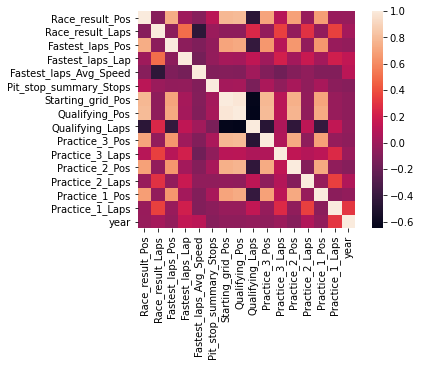

In [17]:
sns.heatmap(df_numerical.corr(), annot=False, square=True)

In [18]:
def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')

    stats.probplot(resid, dist="norm", plot=axes[2])

    fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

In [19]:
X = df_numerical[['Race_result_Laps','Fastest_laps_Pos','Fastest_laps_Lap',
                      'Fastest_laps_Avg_Speed','Pit_stop_summary_Stops','Starting_grid_Pos', 'Qualifying_Pos',
                      'Qualifying_Laps','Practice_3_Pos','Practice_3_Laps','Practice_2_Pos','Practice_2_Laps',
                      'Practice_1_Pos', 'Practice_1_Laps','year']]
y = df_numerical['Race_result_Pos']

In [20]:
#Create the model
model = sm.OLS(y, sm.add_constant(X)) 

#Fit
fit = model.fit()

#Print out summary
fit.summary()


/Users/bats/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Race_result_Pos   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     693.0
Date:                Fri, 01 Oct 2021   Prob (F-statistic):               0.00
Time:                        08:08:56   Log-Likelihood:                -10352.
No. Observations:                4190   AIC:                         2.074e+04
Df Residuals:                    4174   BIC:                         2.084e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -105.1505     22.960     -4.580      0.000    -150.165     -60.136
Race_result_Laps          -0.0523      0.007     -7.286      0.000      -0.066      -0.038
Fastest_laps_Pos           0.2908      0.012     24.021      0.000       0.267       0.315
Fastest_laps_Lap           0.0090      0.004      2.329      0.020       0.001       0.017
Fastest_laps_Avg_Speed    -0.0004      0.003     -0.166      0.868      -0.005       0.005
Pit_stop_summary_Stops     0.6861      0.049     13.979      0.000       0.590       0.782
Starting_grid_Pos          0.1580      0.036      4.403      0.000       0.088       0.228
Qualifying_Pos             0.2380      0.039      6.101      0.000       0.162       0.315
Qualifying_Laps            0.0881      0.011      7.747      0.000       0.066       0.110
Practice_3_Pos             0.0599      0.013      4.789      0.000       0.035       0.084
Practice_3_Laps            0.0201      0.010      1.947      0.052      -0.000       0.040
Practice_2_Pos             0.0589      0.012      4.760      0.000       0.035       0.083
Practice_2_Laps            0.0215      0.005      4.024      0.000       0.011       0.032
Practice_1_Pos             0.0681      0.012      5.739      0.000       0.045       0.091
Practice_1_Laps        -6.149e-05      0.007     -0.008      0.993      -0.015       0.014
year                       0.0519      0.011      4.546      0.000       0.030       0.074
==============================================================================
Omnibus:                      543.565   Durbin-Watson:                   1.350
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1250.222
Skew:                           0.762   Prob(JB):                    3.29e-272
Kurtosis:                       5.200   Cond. No.                     1.05e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

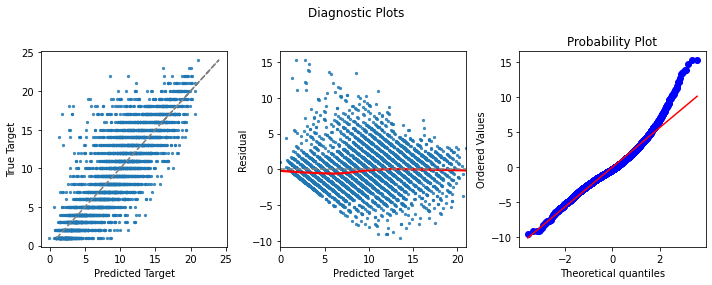

In [21]:
diagnostic_plots(fit.fittedvalues, y, fit.resid)

# Feature Engineering Part 1

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [23]:
#function to calculate VIF - help it remove features before modeling
def vif(df_X):
    '''
    Calculate the VIF for each feature of df_X (a Pandas DataFrame).
    '''
    vif_data = [variance_inflation_factor(df_X.values, i)
                for i in range(df_X.shape[1])]
    
    return pd.Series(vif_data, index=df_X.columns)

In [24]:
vif(df.loc[:,['Race_result_Laps',
       'Fastest_laps_Pos', 'Fastest_laps_Lap', 'Fastest_laps_Time',
       'Fastest_laps_Avg_Speed', 'Pit_stop_summary_Stops',
       'Pit_stop_summary_Total', 'Starting_grid_Pos', 'Starting_grid_Time',
       'Qualifying_Pos', 'Qualifying_Q1', 'Qualifying_Q2', 'Qualifying_Q3',
       'Qualifying_Laps', 'Practice_3_Pos', 'Practice_3_Time',
       'Practice_3_Laps', 'Practice_2_Pos', 'Practice_2_Time',
       'Practice_2_Laps', 'Practice_1_Pos', 'Practice_1_Time',
       'Practice_1_Laps']])

Race_result_Laps          6.511186e+01
Fastest_laps_Pos          9.510220e+00
Fastest_laps_Lap          1.845899e+01
Fastest_laps_Time         9.445348e+02
Fastest_laps_Avg_Speed    5.872933e+01
Pit_stop_summary_Stops    6.857605e+00
Pit_stop_summary_Total    1.332792e+00
Starting_grid_Pos         9.600428e+01
Starting_grid_Time        7.091717e+07
Qualifying_Pos            1.155979e+02
Qualifying_Q1             1.671040e+03
Qualifying_Q2             4.382292e+03
Qualifying_Q3             7.091828e+07
Qualifying_Laps           1.901031e+01
Practice_3_Pos            1.209323e+01
Practice_3_Time           8.518957e+02
Practice_3_Laps           2.028856e+01
Practice_2_Pos            1.198872e+01
Practice_2_Time           7.555538e+02
Practice_2_Laps           1.761168e+01
Practice_1_Pos            1.067496e+01
Practice_1_Time           9.398836e+02
Practice_1_Laps           1.585999e+01
dtype: float64

In [25]:
#Starting_grid_Time, Qualifying_Q3, Qualifying_Pos very high, drop
drop_2 = ['Starting_grid_Time','Qualifying_Q3', 'Qualifying_Pos']
df.drop(columns = drop_2, inplace=True)
vif(df.loc[:,['Race_result_Laps','Fastest_laps_Pos', 'Fastest_laps_Lap', 'Fastest_laps_Time',
              'Fastest_laps_Avg_Speed', 'Pit_stop_summary_Stops','Pit_stop_summary_Total', 'Starting_grid_Pos',
              'Qualifying_Q1', 'Qualifying_Q2','Qualifying_Laps', 'Practice_3_Pos', 'Practice_3_Time',
              'Practice_3_Laps', 'Practice_2_Pos', 'Practice_2_Time',
              'Practice_2_Laps', 'Practice_1_Pos', 'Practice_1_Time','Practice_1_Laps']])

Race_result_Laps            64.828793
Fastest_laps_Pos             9.313957
Fastest_laps_Lap            18.330422
Fastest_laps_Time          935.467310
Fastest_laps_Avg_Speed      58.620928
Pit_stop_summary_Stops       6.840373
Pit_stop_summary_Total       1.329625
Starting_grid_Pos           17.930311
Qualifying_Q1             1660.662504
Qualifying_Q2             1495.043694
Qualifying_Laps             17.746203
Practice_3_Pos              11.946413
Practice_3_Time            851.809964
Practice_3_Laps             20.222646
Practice_2_Pos              11.745757
Practice_2_Time            754.405622
Practice_2_Laps             17.590631
Practice_1_Pos              10.481775
Practice_1_Time            936.974390
Practice_1_Laps             15.812696
dtype: float64

# Train and Validate Models

In [26]:
#Separate our features from our target
X_ = df.loc[:,['Fastest_laps_Pos', 'Fastest_laps_Lap', 'Fastest_laps_Time',
       'Fastest_laps_Avg_Speed', 'Pit_stop_summary_Stops',
       'Pit_stop_summary_Total', 'Starting_grid_Pos','Qualifying_Q1', 'Qualifying_Q2', 
       'Qualifying_Laps', 'Practice_3_Pos', 'Practice_3_Time',
       'Practice_3_Laps', 'Practice_2_Pos', 'Practice_2_Time',
       'Practice_2_Laps', 'Practice_1_Pos', 'Practice_1_Time',
       'Practice_1_Laps']]

y_ = df['Race_result_Pos']
#Split the data 60 - 20 - 20 train/val/test

X, X_test, y, y_test = train_test_split(X_, y_, test_size=.2, random_state=10) #hold out 20% of the data for final testing

In [27]:
#use Lasso model to determine if additional features need to be dropped
std = StandardScaler()
std.fit(X.values)
X_tr = std.transform(X.values)

lr_model_lasso = Lasso(alpha=0.01)
lr_model_lasso.fit(X_tr, y)

list(zip(X.columns, lr_model_lasso.coef_))

[('Fastest_laps_Pos', 1.7263650923327047),
 ('Fastest_laps_Lap', 0.07637542528868355),
 ('Fastest_laps_Time', 0.0),
 ('Fastest_laps_Avg_Speed', 0.2270365800137647),
 ('Pit_stop_summary_Stops', 0.6645815655535745),
 ('Pit_stop_summary_Total', -0.19990778402629378),
 ('Starting_grid_Pos', 2.1916788365368687),
 ('Qualifying_Q1', -0.16931547384203163),
 ('Qualifying_Q2', -0.0),
 ('Qualifying_Laps', 0.29692959485355563),
 ('Practice_3_Pos', 0.45868342590916106),
 ('Practice_3_Time', 0.22235176989685368),
 ('Practice_3_Laps', 0.0743533654737751),
 ('Practice_2_Pos', 0.3745245879435556),
 ('Practice_2_Time', 0.1136478340234742),
 ('Practice_2_Laps', 0.17720675320573004),
 ('Practice_1_Pos', 0.46494330262764805),
 ('Practice_1_Time', -0.0),
 ('Practice_1_Laps', 0.05926235173970692)]

In [28]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y)
lasso_model.alpha_

0.01

In [29]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y)
ridge_model.alpha_

34.489622604057594

In [30]:
#CV 4 model choices w/ standardized data 
kf = KFold(n_splits=5, shuffle=True, random_state = 10)
cv_lm_r2s, cv_lm_reg_r2s, cv_lm_las_r2s, cv_lm_poly_r2s = [], [],[],[] #collect the validation results for both models
    
#empty models
lm = LinearRegression()
lm_reg = Ridge(alpha=34.489)
lm_las = Lasso(alpha=0.01)
lm_poly = LinearRegression()

#simple linear regression
cv_lm_r2s = cross_val_score(lm, X, y, cv=kf, scoring='r2')
    
#ridge with feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)
    
cv_lm_reg_r2s = cross_val_score(lm_reg, X_scaled, y, cv=kf, scoring='r2')
    
#lasso with feature scaling
cv_lm_las_r2s = cross_val_score(lm_las, X_scaled, y, cv=kf, scoring='r2')
    
#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_poly = poly.fit_transform(X.values)
cv_lm_poly_r2s = cross_val_score(lm_poly, X_poly, y, cv=kf, scoring='r2')

print(f'Simple scores: \t{cv_lm_r2s}')
print(f'Ridge scores: \t{cv_lm_reg_r2s} \n')
print(f'Lasso scores: \t{cv_lm_las_r2s} \n')
print(f'Poly 2 scores: \t{cv_lm_poly_r2s} \n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.5f} +- {np.std(cv_lm_r2s):.5f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.5f} +- {np.std(cv_lm_reg_r2s):.5f}')
print(f'Lasso mean cv r^2: {np.mean(cv_lm_las_r2s):.5f} +- {np.std(cv_lm_las_r2s):.5f}')
print(f'Poly 2 mean cv r^2: {np.mean(cv_lm_poly_r2s):.5f} +- {np.std(cv_lm_poly_r2s):.5f}')

Simple scores: 	[0.73784059 0.70880348 0.72231047 0.69457857 0.68879314]
Ridge scores: 	[0.73665044 0.70882268 0.72274783 0.69552803 0.68927883] 

Lasso scores: 	[0.73780244 0.70772056 0.72302163 0.69595957 0.68945411] 

Poly 2 scores: 	[0.70720094 0.70100127 0.70556148 0.67701724 0.67844991] 

Simple mean cv r^2: 0.71047 +- 0.01797
Ridge mean cv r^2: 0.71061 +- 0.01738
Lasso mean cv r^2: 0.71079 +- 0.01769
Poly 2 mean cv r^2: 0.69385 +- 0.01332


# Feature Engineering Part 2

In [31]:
#function to normalize data by race
def norm_race_data(col):
    '''
    Input string column name of dataframe, df,
    to normalize data by race. 
    '''
    mean = df.groupby(['year','location'])[col].transform('mean')
    std = df.groupby(['year','location'])[col].transform('std')
    return (df[col] - mean)/std

In [32]:
#save copy of df for raw engineering
df_raw = df.copy()

#normalize track based time data
track_time_series_list = ['Fastest_laps_Avg_Speed','Fastest_laps_Lap','Fastest_laps_Time','Qualifying_Q1','Qualifying_Q2',
                          'Practice_3_Time','Practice_2_Time','Practice_1_Time']
for col in track_time_series_list:  
    df[col] = norm_race_data(col)
df #sanity check

,Race_result_Pos,Driver,Race_result_Car,Race_result_Laps,Fastest_laps_Pos,Fastest_laps_Lap,Fastest_laps_Time,Fastest_laps_Avg_Speed,Pit_stop_summary_Stops,Pit_stop_summary_Total,...,Practice_3_Time,Practice_3_Laps,Practice_2_Pos,Practice_2_Time,Practice_2_Laps,Practice_1_Pos,Practice_1_Time,Practice_1_Laps,location,year
1,1,Lewis Hamilton HAM,Mercedes,56.0,4.0,0.606829,-0.675311,0.665316,2.0,48.915,...,-1.352470,14.0,3.0,-0.798351,24.0,4.0,-0.920334,15.0,Bahrain,2021
3,2,Max Verstappen VER,Red Bull Racing Honda,56.0,2.0,0.275832,-1.442100,1.444161,2.0,48.615,...,-2.288308,11.0,1.0,-1.127656,23.0,1.0,-1.482852,12.0,Bahrain,2021
6,3,Valtteri Bottas BOT,Mercedes,56.0,1.0,1.930821,-2.550874,2.593948,3.0,81.725,...,-0.669903,16.0,5.0,-0.607774,23.0,2.0,-1.164768,17.0,Bahrain,2021
8,4,Lando Norris NOR,McLaren Mercedes,56.0,6.0,-0.055166,-0.304096,0.292593,2.0,50.539,...,0.602786,10.0,2.0,-0.994533,25.0,3.0,-0.945951,20.0,Bahrain,2021
11,5,Sergio Perez PER,Red Bull Racing Honda,56.0,3.0,0.606829,-0.719155,0.709402,3.0,72.289,...,-0.602786,11.0,10.0,-0.208404,23.0,6.0,-0.760224,15.0,Bahrain,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12293,8,Pedro de la Rosa DLR,McLaren Mercedes,71.0,12.0,0.156874,1.190041,-1.188334,1.0,27.841,...,-0.596576,15.0,11.0,-0.726195,16.0,5.0,-1.062094,5.0,Brazil,2006
12297,10,Takuma Sato SAT,Super Aguri Honda,70.0,9.0,-1.516446,-0.296059,0.292886,2.0,48.982,...,0.655930,21.0,21.0,-0.031656,27.0,12.0,0.495158,16.0,Brazil,2006
12299,11,Scott Speed SPE,STR Cosworth,70.0,13.0,0.784369,1.350797,-1.347525,2.0,48.339,...,0.221066,18.0,26.0,0.495104,28.0,14.0,0.842947,14.0,Brazil,2006
12303,13,Vitantonio Liuzzi LIU,STR Cosworth,70.0,10.0,0.784369,0.725635,-0.726930,2.0,51.176,...,0.311915,20.0,25.0,0.420395,22.0,15.0,1.021926,8.0,Brazil,2006


In [33]:
df.dropna(inplace=True) #a few data points happen to be equal exactly to the mean, for z score of inf, drop

In [34]:
#Separate our features from our target
X_2 = df.loc[:,['Fastest_laps_Pos', 'Fastest_laps_Lap', 
       'Fastest_laps_Avg_Speed', 'Pit_stop_summary_Stops',
       'Pit_stop_summary_Total', 'Starting_grid_Pos','Qualifying_Q1', 'Qualifying_Q2', 
       'Qualifying_Laps', 'Practice_3_Pos', 'Practice_3_Time',
       'Practice_3_Laps', 'Practice_2_Pos', 'Practice_2_Time',
       'Practice_2_Laps', 'Practice_1_Pos', 'Practice_1_Time',
       'Practice_1_Laps']]

y_2 = df['Race_result_Pos']
#Split the data 60 - 20 - 20 train/val/test

X, X_test, y, y_test = train_test_split(X_2, y_2, test_size=.2, random_state=10) #hold out 20% of the data for final testing


In [35]:
np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2'))

0.7052883457701992

In [36]:
vif(df.loc[:,['Fastest_laps_Pos', 'Fastest_laps_Lap',
              'Fastest_laps_Avg_Speed', 'Pit_stop_summary_Stops','Pit_stop_summary_Total', 'Starting_grid_Pos',
              'Qualifying_Q1', 'Qualifying_Q2','Qualifying_Laps', 'Practice_3_Pos', 'Practice_3_Time',
              'Practice_3_Laps', 'Practice_2_Pos', 'Practice_2_Time',
              'Practice_2_Laps', 'Practice_1_Pos', 'Practice_1_Time','Practice_1_Laps']])

Fastest_laps_Pos          29.812946
Fastest_laps_Lap           1.059420
Fastest_laps_Avg_Speed     8.745796
Pit_stop_summary_Stops     6.231140
Pit_stop_summary_Total     1.248970
Starting_grid_Pos         22.011526
Qualifying_Q1              5.558435
Qualifying_Q2              6.193476
Qualifying_Laps           12.941379
Practice_3_Pos            34.969249
Practice_3_Time            9.710262
Practice_3_Laps           14.894055
Practice_2_Pos            33.649796
Practice_2_Time            9.850733
Practice_2_Laps           13.504635
Practice_1_Pos            33.952667
Practice_1_Time            9.709354
Practice_1_Laps           13.253875
dtype: float64

In [37]:
df_raw['P3_P2_delta'] = df_raw['Practice_3_Time']-df_raw['Practice_2_Time']
df_raw['P2_P1_delta'] = df_raw['Practice_2_Time']-df_raw['Practice_1_Time']
df_raw['Q2_Q1_delta'] = df_raw['Qualifying_Q2']-df_raw['Qualifying_Q1']

In [38]:
vif(df_raw.loc[:,['Fastest_laps_Pos', 'Fastest_laps_Lap',
                  'Fastest_laps_Avg_Speed', 'Pit_stop_summary_Stops','Pit_stop_summary_Total', 'Starting_grid_Pos',
                  'Qualifying_Laps', 'Practice_3_Pos', 'Practice_3_Laps', 'Practice_2_Pos', 'Practice_2_Laps', 'Practice_1_Pos',
                  'Practice_1_Laps','P3_P2_delta','P2_P1_delta','Q2_Q1_delta']])

Fastest_laps_Pos           9.026997
Fastest_laps_Lap          14.460353
Fastest_laps_Avg_Speed    31.314247
Pit_stop_summary_Stops     6.042105
Pit_stop_summary_Total     1.239121
Starting_grid_Pos         16.802958
Qualifying_Laps           14.526445
Practice_3_Pos            11.784514
Practice_3_Laps           18.254771
Practice_2_Pos            11.744430
Practice_2_Laps           16.024354
Practice_1_Pos            10.436797
Practice_1_Laps           14.988326
P3_P2_delta                1.806030
P2_P1_delta                1.791891
Q2_Q1_delta                1.086440
dtype: float64

In [39]:
#Separate our features from our target
X_2 = df_raw.loc[:,['Fastest_laps_Pos', 'Fastest_laps_Lap',
                  'Fastest_laps_Avg_Speed', 'Pit_stop_summary_Stops','Pit_stop_summary_Total', 'Starting_grid_Pos',
                  'Qualifying_Laps', 'Practice_3_Pos', 'Practice_3_Laps', 'Practice_2_Pos', 'Practice_2_Laps', 'Practice_1_Pos',
                  'Practice_1_Laps','P3_P2_delta','P2_P1_delta','Q2_Q1_delta']]

y_2 = df_raw['Race_result_Pos']
#Split the data 60 - 20 - 20 train/val/test

X, X_test, y, y_test = train_test_split(X_2, y_2, test_size=.2, random_state=10) #hold out 20% of the data for final testing
print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')), '+-', np.std(cross_val_score(lm, X, y, cv=kf, scoring='r2')))

0.7097884321639882 +- 0.017361209822112974


In [40]:
(df_raw.groupby('Race_result_Car')['Race_result_Car'].count().sort_values(ascending=False )).head(60)

Race_result_Car
Ferrari                      461
Mercedes                     355
McLaren Mercedes             269
Force India Mercedes         250
Renault                      248
Sauber Ferrari               220
Williams Mercedes            204
STR Ferrari                  168
Red Bull Racing Renault      148
Haas Ferrari                 131
Lotus Renault                 90
Sauber BMW                    89
Toyota                        86
McLaren Renault               81
Red Bull Racing TAG Heuer     81
Williams Toyota               79
Red Bull Racing Honda         77
Alfa Romeo Racing Ferrari     66
McLaren Honda                 63
Honda                         62
Caterham Renault              60
Marussia Cosworth             59
Williams Cosworth             58
HRT Cosworth                  58
RBR Renault                   57
Scuderia Toro Rosso Honda     57
Williams Renault              52
Racing Point BWT Mercedes     51
Marussia Ferrari              47
Virgin Cosworth            

In [41]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and cross validate a linear regression model, and report results
    '''
    lr_model = LinearRegression()
    
    kf = KFold(n_splits=5, shuffle=True, random_state = 10)
    val_score = cross_val_score(lr_model, X, y, cv=kf, scoring='r2')
    
    # report results
    print('\nValidation R^2 score was:', np.mean(val_score))

In [42]:
#try with dummy variables for teams
cars = df_raw.Race_result_Car.value_counts()
other_cars = list(cars[cars <= 50].index)

df_raw['Race_result_Car'] = df_raw['Race_result_Car'].replace(other_cars, 'Other')
my_col = ['Fastest_laps_Pos', 'Fastest_laps_Lap',
                  'Fastest_laps_Avg_Speed', 'Pit_stop_summary_Stops','Pit_stop_summary_Total', 'Starting_grid_Pos',
                  'Qualifying_Laps', 'Practice_3_Pos', 'Practice_3_Laps', 'Practice_2_Pos', 'Practice_2_Laps', 'Practice_1_Pos',
                  'Practice_1_Laps','P3_P2_delta','P2_P1_delta','Q2_Q1_delta','Race_result_Car']
split_and_validate(pd.get_dummies(df_raw[my_col], drop_first=False), df_raw['Race_result_Pos'])


Validation R^2 score was: 0.7088514211711743


In [43]:
#try with dummy variables for drivers
drivers = df_raw.Driver.value_counts()
other_drivers = list(drivers[drivers <= 25].index)

df_raw['Driver'] = df_raw['Driver'].replace(other_cars, 'Other')
my_col = ['Fastest_laps_Pos', 'Fastest_laps_Lap',
                  'Fastest_laps_Avg_Speed', 'Pit_stop_summary_Stops','Pit_stop_summary_Total', 'Starting_grid_Pos',
                  'Qualifying_Laps', 'Practice_3_Pos', 'Practice_3_Laps', 'Practice_2_Pos', 'Practice_2_Laps', 'Practice_1_Pos',
                  'Practice_1_Laps','P3_P2_delta','P2_P1_delta','Q2_Q1_delta','Driver']
split_and_validate(pd.get_dummies(df_raw[my_col], drop_first=False), df_raw['Race_result_Pos'])


Validation R^2 score was: 0.7027387576009696


In [44]:
vif(df_raw.loc[:,['Fastest_laps_Pos', 'Fastest_laps_Lap',
                  'Fastest_laps_Avg_Speed', 'Pit_stop_summary_Stops','Pit_stop_summary_Total', 'Starting_grid_Pos',
                  'Qualifying_Laps', 'Practice_3_Pos', 'Practice_3_Laps', 'Practice_2_Pos', 'Practice_2_Laps', 'Practice_1_Pos',
                  'Practice_1_Laps','P3_P2_delta','P2_P1_delta','Q2_Q1_delta']])

Fastest_laps_Pos           9.026997
Fastest_laps_Lap          14.460353
Fastest_laps_Avg_Speed    31.314247
Pit_stop_summary_Stops     6.042105
Pit_stop_summary_Total     1.239121
Starting_grid_Pos         16.802958
Qualifying_Laps           14.526445
Practice_3_Pos            11.784514
Practice_3_Laps           18.254771
Practice_2_Pos            11.744430
Practice_2_Laps           16.024354
Practice_1_Pos            10.436797
Practice_1_Laps           14.988326
P3_P2_delta                1.806030
P2_P1_delta                1.791891
Q2_Q1_delta                1.086440
dtype: float64

# Final Model Choice and Testing

In [45]:
#try interpretable interaction terms
df_raw['SG_Pos_Q_Laps'] = df_raw['Starting_grid_Pos']*df_raw['Qualifying_Laps']
df_raw['P3_Pos_P3_Laps'] = df_raw['Practice_3_Pos']*df_raw['Practice_3_Laps'] #dont include
df_raw['P2_Pos_P2_Laps'] = df_raw['Practice_2_Pos']*df_raw['Practice_2_Laps'] #dont include
df_raw['P1_Pos_P1_Laps'] = df_raw['Practice_1_Pos']*df_raw['Practice_1_Laps'] #dont include
df_raw['FL_avg_p_laps'] = df_raw['Fastest_laps_Avg_Speed']*(df_raw['Qualifying_Laps']+df_raw['Practice_3_Laps']+
                                                            df_raw['Practice_2_Laps']+df_raw['Practice_1_Laps'])

df_raw['FL_avg_p_laps']
#Separate our features from our target
X_2 = df_raw.loc[:,['Fastest_laps_Pos', 'Fastest_laps_Lap','SG_Pos_Q_Laps','FL_avg_p_laps',
                  'Fastest_laps_Avg_Speed', 'Pit_stop_summary_Stops','Pit_stop_summary_Total', 'Starting_grid_Pos',
                  'Qualifying_Laps', 'Practice_3_Pos', 'Practice_3_Laps', 'Practice_2_Pos', 'Practice_2_Laps', 'Practice_1_Pos',
                  'Practice_1_Laps','P3_P2_delta','P2_P1_delta','Q2_Q1_delta']]

y_2 = df_raw['Race_result_Pos']
#Split the data 60 - 20 - 20 train/val/test

X, X_test, y, y_test = train_test_split(X_2, y_2, test_size=.2, random_state=10) #hold out 20% of the data for final testing
print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')), '+-', np.std(cross_val_score(lm, X, y, cv=kf, scoring='r2')))


0.7108740021207732 +- 0.017002988046784462


In [59]:
#fit on all training data now
lm.fit(X, y)

#test with test data
print(lm.score(X_test, y_test))
print(mean_absolute_error(y_test,y_hat))

0.6837130717142541
2.1865741915256267


In [47]:
print(lm.intercept_)
list(zip(X_2.columns, lm.coef_))

-9.764186250020272


[('Fastest_laps_Pos', 0.3081082345283153),
 ('Fastest_laps_Lap', 0.0030151833865958333),
 ('SG_Pos_Q_Laps', 0.005428707475930879),
 ('FL_avg_p_laps', -0.00032723233807656593),
 ('Fastest_laps_Avg_Speed', 0.039310549843889965),
 ('Pit_stop_summary_Stops', 0.7398098241638441),
 ('Pit_stop_summary_Total', -0.0006574439804080518),
 ('Starting_grid_Pos', 0.2716910328062404),
 ('Qualifying_Laps', 0.0583478200773008),
 ('Practice_3_Pos', 0.07715117871465386),
 ('Practice_3_Laps', 0.0746141472807227),
 ('Practice_2_Pos', 0.06300869307746607),
 ('Practice_2_Laps', 0.08276261980617561),
 ('Practice_1_Pos', 0.08034598029575878),
 ('Practice_1_Laps', 0.0693045076664526),
 ('P3_P2_delta', 0.006308467953204687),
 ('P2_P1_delta', 0.015882648380601518),
 ('Q2_Q1_delta', 0.009752555817026927)]

In [48]:
#find 3 examples
y_hat = lm.predict(X_test)
print(y_hat[-8], y_test.iloc[-8])
print(y_hat[-3], y_test.iloc[-3])
print(y_hat[10], y_test.iloc[10])

0.7730989249245859 1
12.403223531853564 12
19.44904477359958 21


In [49]:
X_test.iloc[10,:]

Fastest_laps_Pos             23.000
Fastest_laps_Lap             54.000
SG_Pos_Q_Laps                88.000
FL_avg_p_laps             10893.560
Fastest_laps_Avg_Speed      187.820
Pit_stop_summary_Stops        3.000
Pit_stop_summary_Total       83.054
Starting_grid_Pos            22.000
Qualifying_Laps               4.000
Practice_3_Pos               23.000
Practice_3_Laps              14.000
Practice_2_Pos               24.000
Practice_2_Laps              22.000
Practice_1_Pos               24.000
Practice_1_Laps              18.000
P3_P2_delta                  -1.359
P2_P1_delta                  -1.705
Q2_Q1_delta                   0.000
Name: 6669, dtype: float64

In [50]:
df_raw.loc[2490,:]

Race_result_Pos                            1
Driver                    Lewis Hamilton HAM
Race_result_Car                     Mercedes
Race_result_Laps                        51.0
Fastest_laps_Pos                         1.0
Fastest_laps_Lap                        48.0
Fastest_laps_Time                     90.621
Fastest_laps_Avg_Speed               234.025
Pit_stop_summary_Stops                   1.0
Pit_stop_summary_Total                27.733
Starting_grid_Pos                        1.0
Qualifying_Q1                         99.069
Qualifying_Q2                         87.893
Qualifying_Laps                         25.0
Practice_3_Pos                           1.0
Practice_3_Time                       88.063
Practice_3_Laps                         18.0
Practice_2_Pos                           2.0
Practice_2_Time                       88.543
Practice_2_Laps                         35.0
Practice_1_Pos                           2.0
Practice_1_Time                       89.184
Practice_1

In [51]:
df_raw.loc[8517,:]

Race_result_Pos                             12
Driver                       Paul di Resta DIR
Race_result_Car           Force India Mercedes
Race_result_Laps                          53.0
Fastest_laps_Pos                          13.0
Fastest_laps_Lap                          43.0
Fastest_laps_Time                        97.97
Fastest_laps_Avg_Speed                 213.383
Pit_stop_summary_Stops                     3.0
Pit_stop_summary_Total                  65.481
Starting_grid_Pos                         12.0
Qualifying_Q1                           93.499
Qualifying_Q2                           92.746
Qualifying_Laps                           10.0
Practice_3_Pos                            15.0
Practice_3_Time                          93.99
Practice_3_Laps                           16.0
Practice_2_Pos                            15.0
Practice_2_Time                         94.601
Practice_2_Laps                           33.0
Practice_1_Pos                            14.0
Practice_1_Ti

In [52]:
df_raw.loc[6669,:]

Race_result_Pos                             21
Driver                    Pedro de la Rosa DLR
Race_result_Car                   HRT Cosworth
Race_result_Laps                          54.0
Fastest_laps_Pos                          23.0
Fastest_laps_Lap                          54.0
Fastest_laps_Time                      106.244
Fastest_laps_Avg_Speed                  187.82
Pit_stop_summary_Stops                     3.0
Pit_stop_summary_Total                  83.054
Starting_grid_Pos                         22.0
Qualifying_Q1                          102.914
Qualifying_Q2                          102.914
Qualifying_Laps                            4.0
Practice_3_Pos                            23.0
Practice_3_Time                        102.464
Practice_3_Laps                           14.0
Practice_2_Pos                            24.0
Practice_2_Time                        103.823
Practice_2_Laps                           22.0
Practice_1_Pos                            24.0
Practice_1_Ti

Text(0.5, 1.0, 'Normal Q-Q plot')

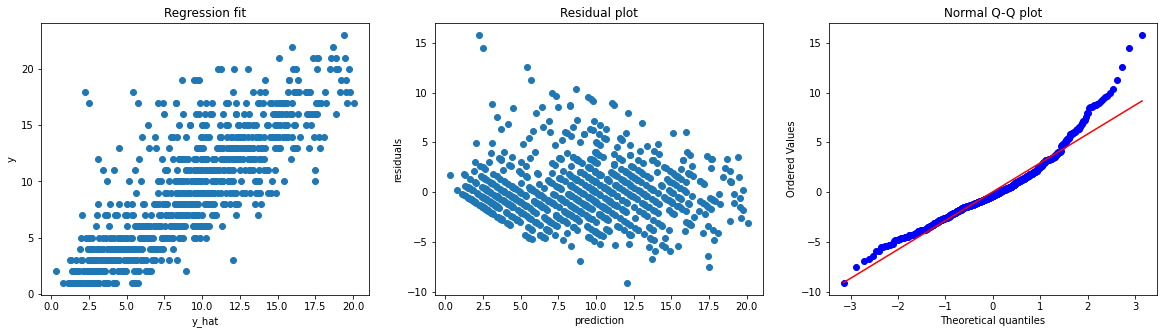

In [53]:
plt.figure(figsize=(20,5))
    
plt.subplot(1, 3, 1)
plt.scatter(y_hat,y_test)
#plt.plot(y_hat, y_test, color='blue',linewidth=1)
plt.title("Regression fit")
plt.xlabel("y_hat")
plt.ylabel("y")
    
plt.subplot(1, 3, 2)
res = y_test - y_hat
plt.scatter(y_hat, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")
    
plt.subplot(1, 3, 3)
#Generates a probability plot of sample data against the quantiles of a 
# specified theoretical distribution 
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

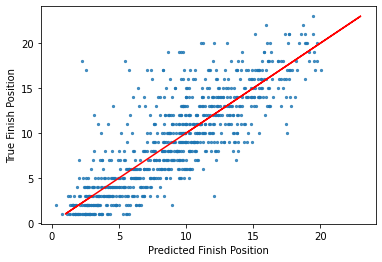

In [60]:
g1 = sns.regplot(x=y_hat, y=y_test, ci=False, fit_reg=False, line_kws={'color': 'blue'}, scatter_kws={'s': 5})
g1.set_xlabel('Predicted Finish Position')
g1.set_ylabel('True Finish Position')
g1.plot(y_test, y_test, color='red')